# Text2StereoWithBaseline

### Delete Files
Delete unnecessary files.

In [2]:
!rm -rf /content/sample_data
!rm -rf /content/__MACOSX/
!rm -rf /content/lora_out
!rm -rf /content/output
!rm -rf /content/fixed_baselines.zip

### Mount Google Drive

We mount the google drive folder, s.t. we have access to the training data.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Imports

In [3]:
import os, json, math, random, torch
from collections import defaultdict
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Sampler
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler, DDPMScheduler
from torch import nn, optim
from tqdm import tqdm
from peft import LoraConfig, get_peft_model, get_peft_model_state_dict
import matplotlib.pyplot as plt
import numpy as np

### Configuration

In [19]:
# directories
DATA_DIR   = "/content/drive/MyDrive/Colab Notebooks/fixed_baselines"
MODEL_ID   = "runwayml/stable-diffusion-v1-5"
HF_CACHE   = "/content/hf_cache"
OUTPUT_DIR = "/content/lora_out"

# LoRa
R_UNET     = 16 # rank unet
R_TE       = 8  # rank text-encoder
LR         = 3e-5
BATCHSIZE  = 1
IMAGE_SIZE = (384, 384)

# training
STEPS_PER_EPOCH  = 2000
MAX_STEPS        = 6000
GRAD_ACCUM       = 4
WEIGHT_DECAY     = 1e-2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
assert DEVICE == "cuda", "Runtime -> Change runtime type -> GPU"

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(HF_CACHE, exist_ok=True)

### Helpers

In [5]:
# returns baseline/fov for a meta file
def _read_meta(meta_path):
    baseline, fov = 0.08, 60.0
    if os.path.exists(meta_path):
        with open(meta_path, "r") as f:
            m = json.load(f)

        if "baseline_m" in m:
          baseline = float(m["baseline_m"])

        if "fov_deg"   in m:
          fov = float(m["fov_deg"])

        # Fallbacks
        # No FOV in meta file
        if (m.get("fov_deg") is None) and "fx" in m and "width" in m:
            # calculate fov from width and focal length
            fov = math.degrees(2.0 * math.atan((float(m["width"])*0.5)/float(m["fx"])))

        # No baseline in meta file
        if (m.get("baseline_m") is None) and "cam_left" in m and "cam_right" in m:
            # calculate baseline from x coordinates of both cameras
            try:
                tx_l = float(m["cam_left"]["matrix_world"][0][3])
                tx_r = float(m["cam_right"]["matrix_world"][0][3])
                baseline = abs(tx_r - tx_l)
            except Exception:
                pass
    return max(0.01, min(1.0, baseline)), max(20.0, min(120.0, fov))





def get_prompt_embeds(pipe, prompts, device):
    try:
        enc = pipe.encode_prompt(
            prompts,
            device=device,
            num_images_per_prompt=1,
            do_classifier_free_guidance=False,
            negative_prompt=None,
        )
        return enc[0] if isinstance(enc, tuple) else enc
    except Exception:
        tok = pipe.tokenizer(
            prompts, padding="max_length",
            max_length=pipe.tokenizer.model_max_length,
            truncation=True, return_tensors="pt",
        )
        input_ids = tok.input_ids.to(device)
        with torch.no_grad():
            enc = pipe.text_encoder(input_ids)[0]
        return enc

### Dataset
We need to describe our stereo dataset. To do this we collect the most important properties of the images in `self.samples`. For each image (left or right) we will save
- `image path`
- `prompt`
- `btag` (baseline)

inside of a dictionary.

We currently don't know the implications of very large baselines. Since earlier trainigsdata may include stereo images with large baselines, we will ignore all stereo images with a baseline larger then `0.2`.
We currently also ignore the `fov` property of the meta data.

In [6]:
from collections import Counter
class StereoPairDataset(Dataset):
    def __init__(self, root_dir, size=(384, 384)):
        self.root_dir = root_dir
        self.size = size
        self.samples = self._collect()
        print("Baseline tags:", Counter([s["btag"] for s in self.samples]))


    def _find(self, d, scene, tag):
        for ext in (".png", ".jpg", ".jpeg"):
            p = os.path.join(d, f"{scene}_{tag}{ext}")
            if os.path.exists(p):
                return p
        return None

    def _collect(self):
        S = []
        for scene in sorted(os.listdir(self.root_dir)):
            d = os.path.join(self.root_dir, scene)
            if not os.path.isdir(d):
                continue

            L = self._find(d, scene, "left")
            R = self._find(d, scene, "right")
            if not (L and R):
                continue

            meta = os.path.join(d, f"{scene}_meta.json")
            B, _ = _read_meta(meta) if os.path.exists(meta) else (0.08, 60.0)
            if B > 0.20:
                continue

            btag = f"<B_{int(round(B*100)):02d}>"
            S.append({
                "left_path":  L,
                "right_path": R,
                "btag": btag,
            })

        if not S:
            raise RuntimeError(f"No stereo pairs found under {self.root_dir}")
        return S

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]
        L = Image.open(s["left_path"]).convert("RGB").resize(self.size)
        R = Image.open(s["right_path"]).convert("RGB").resize(self.size)
        return {
            "left":  L,
            "right": R,
            "btag":  s["btag"],
        }


### Baseline Sampling
Since we strive for an uniform distribution of baselines in our trainingsdata, we would like to categorize the images in baseline buckets.
For example:
```
self.buckets["<B_06>"] = [0, 5, 9, ...]
self.buckets["<B_08>"] = [1, 3, 7, ...]
```
this allows us to uniformly train our model without distribution bias which could result from non-uniform trainings data.

In [7]:
class BalancedByBaselineSampler(Sampler):
    """Round-robin über Baseline-Buckets; pro Step zufälliger Index aus Bucket."""
    def __init__(self, samples, batch_size=1, steps_per_epoch=2000):
        self.buckets = defaultdict(list)
        for i, s in enumerate(samples):
            self.buckets[s["btag"]].append(i)
        self.keys = sorted(self.buckets.keys())
        self.batch_size = batch_size
        self.steps = steps_per_epoch

    def __iter__(self):
        k = 0
        for _ in range(self.steps * self.batch_size):
            key = self.keys[k % len(self.keys)]
            yield random.choice(self.buckets[key])
            k += 1

    def __len__(self):
        return self.steps * self.batch_size

In [8]:
class StereoUNetWrapper(nn.Module):
    """
    Wrappt das bestehende SD-UNet, injiziert left_latent über 1x1-Conv als Residual.
    Nur die 1x1-Conv + LoRA im UNet werden trainiert.
    """
    def __init__(self, base_unet, latent_channels=4):
        super().__init__()
        self.unet = base_unet
        # left_latent hat gleiche Kanalzahl wie right_latent (4)
        # Wir projizieren ihn mit 1x1 Conv auf 4 Kanäle und addieren
        self.left_proj = nn.Conv2d(latent_channels, latent_channels, kernel_size=1)

    def forward(self, noisy_right_latent, t, encoder_hidden_states, left_latent):
        # left_latent: (B,4,H,W), ohne Noise
        left_feat = self.left_proj(left_latent)
        # simple additive conditioning
        x = noisy_right_latent + left_feat
        return self.unet(x, t, encoder_hidden_states=encoder_hidden_states)


### Base Pipeline
Now we need to load the Stable Diffusion pipeline from the pretrained model `stable-diffusion-v1-5` from HF.
Important terms:

`Text Encoder`: Representation of ***text prompt*** in UNet. Translates prompt into embeddings, consumed by UNet (numerical vector).

Prompt → Tokenizer → Token-IDs → Text-Encoder → Embeddings → UNet

`VAE`: Representation of ***image pixels*** in UNet. Translates image pixels into feature map, consumed by UNet.

Image → VAE-Encoder → Latent → UNet → denoised Latent → VAE-Decoder → Image

`UNet`: Diffusion network, resposible for denoising the image in each step.

(noisy latent + timestep, text embeddings) → UNet → predicted noise → (iterative denoising) → final latent → VAE-Decoder → Image





In [9]:
pipe = StableDiffusionPipeline.from_pretrained(
    MODEL_ID,
    cache_dir=HF_CACHE,
    safety_checker=None,
    requires_safety_checker=False
)

# faster image generation
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

# reduces VRAM usage
pipe.enable_vae_tiling()
pipe.vae.enable_slicing()
pipe.enable_attention_slicing()

# execute pipeline on DEVICE
pipe.to(DEVICE)

vae = pipe.vae
base_unet = pipe.unet

# use float16 for faster image generation
#for m in [pipe.unet, pipe.vae, pipe.text_encoder]:
#    m.to(device="cuda", dtype=torch.float16)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

### LoRa Configs

We use `stable-diffusion-v1-5` as our base model and add LoRa Layer on top. Before we do this we will freeze the parameters of our base model. This way only the newly added LoRA weights are trained.



In [10]:
# freeze parameters (UNet, VAE, text encoder) of our base model
for p in base_unet.parameters(): p.requires_grad_(False)
for p in vae.parameters():      p.requires_grad_(False)
for p in pipe.text_encoder.parameters(): p.requires_grad_(False)

now we will configure how the LoRa layers are added (for the UNet and the text-encoder). We define the following parameters:
- `r` rank of matrices → Increasing `r` increase number of parameters.
- `lora_alpha` scale factor of activation → Increases LoRa activation without more parameters.
- `lora_dropout` can be ignored for stable diffusion.
- `bias` none standard for stable diffusion.
- `target_modules` baseline control acts on spacial relationships.
- `init_lora_weights` initializes weights with normal distribution.

In [11]:
# UNet-LoRA
lora_cfg_unet = LoraConfig(
    r=R_UNET,
    lora_alpha=R_UNET*2,
    lora_dropout=0.0,
    bias="none",
    target_modules=["to_q","to_k","to_v","to_out.0"],
    init_lora_weights="gaussian",
)
# add weights to target modules defined in cfg.
pipe.unet.add_adapter(lora_cfg_unet, adapter_name="stereo")
# LoRa is able to have several adapters. Here we add our stereo adapter.
pipe.unet.set_adapters(["stereo"])

# we saved our unet weights as float16 instead of float32 to make it faster.
UNET_DTYPE = torch.float32 #next(pipe.unet.parameters()).dtype

# since lora weights are initialized as float32 we have to convert them
#for n, p in pipe.unet.named_parameters():
#    if "lora" in n: p.data = p.data.to(UNET_DTYPE)

stereo_unet = StereoUNetWrapper(base_unet).to(DEVICE)

# Text-Encoder-LoRA
te_lora = LoraConfig(
    r=R_TE,
    lora_alpha=R_TE*2,
    lora_dropout=0.0,
    bias="none",
    target_modules=["q_proj","k_proj","v_proj","out_proj"]
)
# add new weights to current text-encoder
pipe.text_encoder = get_peft_model(pipe.text_encoder, te_lora).to(DEVICE)

### Baseline sampling - Applied
Now we load the data and register the new tokens. After that we generate uniform indice buckets for the baselines `<B_xx>` (see `BalancedByBaselineSampler`) and retrieve consecutively an index for the current baseline.

For example:
```
Step 1 → B_06 → 9
Step 2 → B_08 → 1
Step 3 → B_10 → 6
Step 4 → B_06 → 0
Step 5 → B_08 → 7
Step 6 → B_10 → 4
```

In [12]:
# load dataset
ds = StereoPairDataset(DATA_DIR, size=IMAGE_SIZE)

# register all baseline tokens <B_xx> and <LEFT>, <RIGHT> token
extra_tokens = sorted({s["btag"] for s in ds.samples} | {"<LEFT>", "<RIGHT>"})
added = pipe.tokenizer.add_tokens(list(extra_tokens))
if added > 0:
    pipe.text_encoder.resize_token_embeddings(len(pipe.tokenizer))

# sample data
sampler = BalancedByBaselineSampler(ds.samples, batch_size=BATCHSIZE, steps_per_epoch=STEPS_PER_EPOCH)
# choose index via round robin
dl = DataLoader(ds, batch_size=BATCHSIZE, sampler=sampler, collate_fn=lambda b: b, num_workers=0)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Baseline tags: Counter({'<B_12>': 624, '<B_20>': 612, '<B_14>': 590, '<B_10>': 583, '<B_08>': 557, '<B_16>': 554, '<B_06>': 546, '<B_18>': 533})


### Optimizer
Filtering all trainable parameters (UNet and text-encoder). Use Adam with weight decay to update LoRa weights for given trainable parameters, learning rate and weight decay.

In [13]:
trainable = []

# LoRA im UNet (stereo_unet.unet)
for n, p in stereo_unet.unet.named_parameters():
    if "lora" in n and p.requires_grad:
        trainable.append(p)

# 1x1 Conv für left_latent
for p in stereo_unet.left_proj.parameters():
    trainable.append(p)

# Text-Encoder-LoRA wie gehabt
for p in pipe.text_encoder.parameters():
    if p.requires_grad:
        trainable.append(p)

opt = optim.AdamW(
    trainable,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    betas=(0.9, 0.99),
)


### Training Configuration
We decide how many noise steps we want to have with `num_train_timesteps`.

In [14]:
train_sched = DDPMScheduler(num_train_timesteps=1000, beta_schedule="scaled_linear")
alphas_cumprod = train_sched.alphas_cumprod.to(DEVICE, dtype=torch.float32)

vae.eval()
pipe.text_encoder.train()
stereo_unet.train()

StereoUNetWrapper(
  (unet): UNet2DConditionModel(
    (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_proj): Timesteps()
    (time_embedding): TimestepEmbedding(
      (linear_1): Linear(in_features=320, out_features=1280, bias=True)
      (act): SiLU()
      (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
    )
    (down_blocks): ModuleList(
      (0): CrossAttnDownBlock2D(
        (attentions): ModuleList(
          (0-1): 2 x Transformer2DModel(
            (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
            (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
            (transformer_blocks): ModuleList(
              (0): BasicTransformerBlock(
                (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
                (attn1): Attention(
                  (to_q): lora.Linear(
                    (base_layer): Linear(in_features=320, out_features=320, bias=False)
                    

### Training Loop
1. Retrieve image and prompt from dataset

2. Image → Latent encoding

3. Add random noise + random timestep t

4. UNet

5. Calculate Loss from (pred - noise)

6. Update LoRA weights

In [20]:
step = 0
pbar = tqdm(total=MAX_STEPS, desc="train")
opt.zero_grad(set_to_none=True)

loss_history = []
step_history = []

while step < MAX_STEPS:
    for batch in dl:
        left_imgs  = [s["left"]  for s in batch]
        right_imgs = [s["right"] for s in batch]
        btags      = [s["btag"]  for s in batch]
        prompts = [f"{b} <RIGHT>" for b in btags]


        with torch.no_grad():
            vae_dtype = next(vae.parameters()).dtype

            px_L = pipe.image_processor.preprocess(left_imgs).to("cuda", dtype=vae_dtype)
            left_latents = vae.encode(px_L).latent_dist.sample().to(UNET_DTYPE) * 0.18215

            px_R = pipe.image_processor.preprocess(right_imgs).to("cuda", dtype=vae_dtype)
            right_latents = vae.encode(px_R).latent_dist.sample().to(UNET_DTYPE) * 0.18215

            noise = torch.randn_like(right_latents, dtype=UNET_DTYPE, device="cuda")
            t = torch.randint(0, train_sched.config.num_train_timesteps, (right_latents.size(0),), device="cuda").long()
            noisy_latents = train_sched.add_noise(right_latents, noise, t)

        prompt_embeds = get_prompt_embeds(pipe, prompts, "cuda").to("cuda", dtype=UNET_DTYPE)

        pred = stereo_unet(
            noisy_right_latent=noisy_latents,
            t=t,
            encoder_hidden_states=prompt_embeds,
            left_latent=left_latents,
        ).sample

        # SNR-Loss
        pred_f  = pred.float()
        noise_f = noise.float()

        snr = (alphas_cumprod[t].float()) / (1.0 - alphas_cumprod[t].float())
        gamma = 5.0
        loss_weight = torch.minimum(snr, torch.full_like(snr, gamma)) / (snr + 1.0)

        per_ex = (pred_f - noise_f).pow(2).mean(dim=(1, 2, 3))
        loss = (loss_weight * per_ex).mean()

        # record loss
        loss_history.append(loss.item())
        step_history.append(step)

        (loss / GRAD_ACCUM).backward()
        if (step + 1) % GRAD_ACCUM == 0:
            torch.nn.utils.clip_grad_norm_(trainable, 1.0)
            opt.step()
            opt.zero_grad(set_to_none=True)

        step += 1
        pbar.set_postfix(loss=f"{loss.item():.4f}")
        pbar.update(1)
        if step >= MAX_STEPS:
            break

pbar.close()
print("Training done.")

train: 100%|██████████| 6000/6000 [2:03:32<00:00,  1.24s/it, loss=0.0283]

Training done.


### Save model

In [21]:
# Tokenizer
pipe.tokenizer.save_pretrained(OUTPUT_DIR)

# UNet-LoRA
pipe.unet.set_adapters(["stereo"])
pipe.save_lora_weights(
    OUTPUT_DIR,
    unet_lora_layers=pipe.unet,
    weight_name="stereo_unet.safetensors",
    safe_serialization=True,
)

# Text-Encoder-LoRA
from peft import get_peft_model_state_dict
te_lora_sd = get_peft_model_state_dict(pipe.text_encoder)
torch.save(te_lora_sd, os.path.join(OUTPUT_DIR, "stereo_te.safetensors"))

torch.save(
    stereo_unet.state_dict(),
    os.path.join(OUTPUT_DIR, "stereo_unet_wrapper.pt")
)

print("Saved StereoUNetWrapper ->", os.path.join(OUTPUT_DIR, "stereo_unet_wrapper.pt"))
print("Saved UNet-LoRA ->", os.path.join(OUTPUT_DIR, "stereo_unet.safetensors"))
print("Saved TE-LoRA   ->", os.path.join(OUTPUT_DIR, "stereo_te.safetensors"))
print("Tokenizer saved ->", OUTPUT_DIR)

/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:300: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


Saved StereoUNetWrapper -> /content/lora_out/stereo_unet_wrapper.pt
Saved UNet-LoRA -> /content/lora_out/stereo_unet.safetensors
Saved TE-LoRA   -> /content/lora_out/stereo_te.safetensors
Tokenizer saved -> /content/lora_out


### Plot Loss

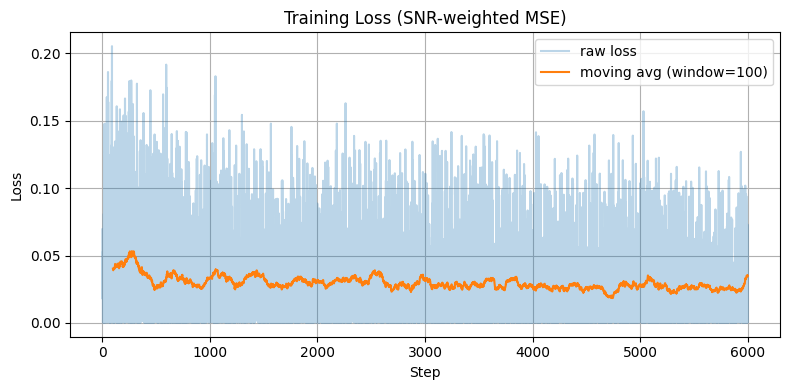

In [22]:
window = 100
if len(loss_history) > window:
    kernel = np.ones(window) / window
    smooth_loss = np.convolve(loss_history, kernel, mode="valid")
    smooth_steps = step_history[window-1:]
else:
    smooth_loss = loss_history
    smooth_steps = step_history

plt.figure(figsize=(8, 4))
plt.plot(step_history, loss_history, alpha=0.3, label="raw loss")
plt.plot(smooth_steps, smooth_loss, label=f"moving avg (window={window})")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss (SNR-weighted MSE)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Download model

In [ ]:
import shutil

# Pfad zu deinem Ordner
folder_path = "/content/lora_out"

# ZIP-Datei erstellen
shutil.make_archive("/content/lora_out", "zip", folder_path)

# Download-Link anzeigen
from google.colab import files
files.download("/content/lora_out.zip")


### Evaluation

In [24]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

# Sampler für Inference (hier DDPMScheduler, du kannst auch DDIM etc. nehmen)
infer_sched = DDPMScheduler(num_train_timesteps=1000, beta_schedule="scaled_linear")

def pil_to_latent(pil_img, vae, device="cuda", dtype=torch.float32):
    """PIL -> VAE-Latent (wie im Training)."""
    px = pipe.image_processor.preprocess([pil_img]).to(device, dtype=next(vae.parameters()).dtype)
    with torch.no_grad():
        lat = vae.encode(px).latent_dist.sample().to(dtype) * 0.18215
    return lat

def latent_to_pil(latents, vae):
    """VAE-Latent -> PIL.Image (uint8)."""
    latents = latents / 0.18215
    with torch.no_grad():
        img = vae.decode(latents).sample
    img = (img / 2 + 0.5).clamp(0, 1)
    img = (img * 255).permute(0, 2, 3, 1).cpu().numpy().astype("uint8")[0]
    return Image.fromarray(img)

def generate_right_image_with_model(left_pil, btag, num_inference_steps=20):
    """
    linkes Bild + Baseline-Tag -> generiertes rechtes Bild (PIL).
    Nutzt dein StereoUNetWrapper + LoRA.
    """
    pipe.text_encoder.eval()
    stereo_unet.eval()
    vae.eval()

    device = "cuda"

    with torch.no_grad():
        # 1) linkes Bild in Latent
        left_latent = pil_to_latent(left_pil, vae, device=device, dtype=UNET_DTYPE)

        # 2) Start-Latent für rechtes Bild: reines Rauschen
        _, _, h, w = left_latent.shape
        right_latent = torch.randn((1, 4, h, w), device=device, dtype=UNET_DTYPE)

        # 3) Prompt-Embeddings
        prompt = f"{btag} <RIGHT>"
        prompt_embeds = get_prompt_embeds(pipe, [prompt], device).to(device, dtype=UNET_DTYPE)

        # 4) Diffusion-Schritte
        infer_sched.set_timesteps(num_inference_steps, device=device)
        latents = right_latent

        for t in infer_sched.timesteps:
            # UNet-Vorhersage
            noise_pred = stereo_unet(
                noisy_right_latent=latents,
                t=t,
                encoder_hidden_states=prompt_embeds,
                left_latent=left_latent,
            ).sample

            # einen Schritt in der Reverse-Diffusion
            latents = infer_sched.step(noise_pred, t, latents).prev_sample

        # 5) Latent -> Bild
        right_img = latent_to_pil(latents, vae)

    return right_img


Baseline tags: Counter({'<B_12>': 624, '<B_20>': 612, '<B_14>': 590, '<B_10>': 583, '<B_08>': 557, '<B_16>': 554, '<B_06>': 546, '<B_18>': 533})
Verwendete Baselines: ['<B_06>', '<B_14>', '<B_20>']
Baseline (cm)  |  mean_abs_u_px  |  std
  6                2.424       0.814
 14                2.275       0.773
 20                2.082       0.539


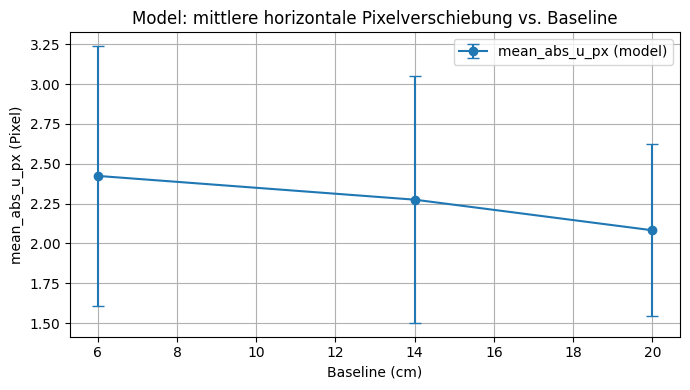

In [29]:
import os
import cv2
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import random


def compute_optical_flow(left_img, right_img):
    """
    Berechnet dichten Flow von left -> right und gibt das Flow-Feld zurück.
    left_img, right_img: np.ndarray (H, W, 3), [0..255], uint8
    """
    # In Graustufen wandeln
    gray_L = cv2.cvtColor(left_img, cv2.COLOR_RGB2GRAY)
    gray_R = cv2.cvtColor(right_img, cv2.COLOR_RGB2GRAY)

    # Farneback-Optical-Flow
    flow = cv2.calcOpticalFlowFarneback(
        gray_L, gray_R,
        None,
        pyr_scale=0.5,
        levels=3,
        winsize=15,
        iterations=3,
        poly_n=5,
        poly_sigma=1.2,
        flags=0
    )
    # flow[..., 0] = horizontale Verschiebung (u), flow[..., 1] = vertikale Verschiebung (v)
    return flow


def mean_abs_u_px(flow):
    """Mittlere absolute horizontale Pixelverschiebung."""
    u = flow[..., 0]  # horizontale Komponente
    return float(np.mean(np.abs(u)))



def evaluate_baseline_disparities_model(dataset, max_per_baseline=10, num_baselines=3):
    """
    Evaluiert dein Modell auf einem Subset:
    - wählt num_baselines Baselines (z.B. min / mid / max)
    - pro Baseline höchstens max_per_baseline Beispiele
    """
    # 1) Indizes pro Baseline sammeln
    indices_by_btag = defaultdict(list)
    for idx in range(len(dataset)):
        btag = dataset[idx]["btag"]
        indices_by_btag[btag].append(idx)

    # 2) Baselines sortieren und 3 auswählen (min / Mitte / max)
    all_btags = sorted(indices_by_btag.keys())
    if len(all_btags) <= num_baselines:
        selected_btags = all_btags
    else:
        mid = len(all_btags) // 2
        selected_btags = [all_btags[0], all_btags[mid], all_btags[-1]]

    print("Verwendete Baselines:", selected_btags)

    stats = defaultdict(list)  # btag -> Liste von mean_abs_u_px

    for btag in selected_btags:
        idx_list = indices_by_btag[btag]
        random.shuffle(idx_list)
        sub_indices = idx_list[:max_per_baseline]

        for idx in sub_indices:
            sample = dataset[idx]
            L_pil = sample["left"]      # PIL
            # btag ist der gleiche wie in der Schleife

            # Modell-generiertes rechtes Bild
            R_pil = generate_right_image_with_model(L_pil, btag)

            L = np.array(L_pil)
            R = np.array(R_pil)

            flow = compute_optical_flow(L, R)
            mu = mean_abs_u_px(flow)
            stats[btag].append(mu)

    # Aggregate
    baselines = []
    mean_disparities = []
    std_disparities = []

    for btag in sorted(stats.keys()):
        values = np.array(stats[btag], dtype=np.float32)
        baselines.append(btag)
        mean_disparities.append(values.mean())
        std_disparities.append(values.std())

    return baselines, np.array(mean_disparities), np.array(std_disparities)

# --- Ausführen ---

eval_ds = StereoPairDataset(DATA_DIR, size=IMAGE_SIZE)

baselines, mean_disp, std_disp = evaluate_baseline_disparities_model(
    eval_ds,
    max_per_baseline=10,
    num_baselines=3,
)

baseline_cm = []
for b in baselines:
    num_str = b.strip("<>").split("_")[1]
    baseline_cm.append(int(num_str))

baseline_cm = np.array(baseline_cm, dtype=np.int32)
order = np.argsort(baseline_cm)
baseline_cm = baseline_cm[order]
mean_disp = mean_disp[order]
std_disp = std_disp[order]

print("Baseline (cm)  |  mean_abs_u_px  |  std")
for b, m, s in zip(baseline_cm, mean_disp, std_disp):
    print(f"{b:3d}           {m:10.3f}      {s:6.3f}")

plt.figure(figsize=(7, 4))
plt.errorbar(
    baseline_cm,
    mean_disp,
    yerr=std_disp,
    fmt="o-",
    capsize=4,
    label="mean_abs_u_px (model)"
)
plt.xlabel("Baseline (cm)")
plt.ylabel("mean_abs_u_px (Pixel)")
plt.title("Model: mittlere horizontale Pixelverschiebung vs. Baseline")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
